## You'll need yet another python package for this notebook:

[Daft](https://docs.daft-pgm.org/en/latest/) is a package to draft probabilistic graphical models

```
conda activate fds
conda install daft
```

In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['figure.figsize'] = [10, 8]

import daft

# Week 10, ASTR 596: Fundamentals of Data Science


## Hierarchical Bayes in Practice; Selection Effects 

### Gautham Narayan 
##### <gsn@illinois.edu>

## Recap:

<img src="hierarchical1.png">

## Recap

So let's look at a few different approaches to the midterm:



<table>
    <col width="300">
    <col width="300">
    <col width="300">
    <tr>
        <td>
            One Observation of one Cepehid (Use PSF fitting to get photometry):
            <img src="HubbleVar.png">
        </td>
        <td>
            One Cepheid (Use Periodogram/GP to get period):
            <img src="Cepheid-variabledb92-600x461.jpg">
        </td>
        <td>
            Many Cepheids in one galaxy (Use MLE to get slope and intercept of PL relation):
            <img src="cepheid_data.png">
        </td>
    </tr>  
</table>

## Recap: PGM for Many Cepehids in One Galaxy

Many Cepheids in one galaxy.


<img src="pgms_cepheids.png">


**This is a multi-level model**

When we first saw this back in week 3, we weren't even Bayesian and didn't worry about things like priors, let alone hyper priors.

## Recap: PGM for many Cepheids in many galaxies

This is what the midterm question prompted:

<img src="keygals.jpg">

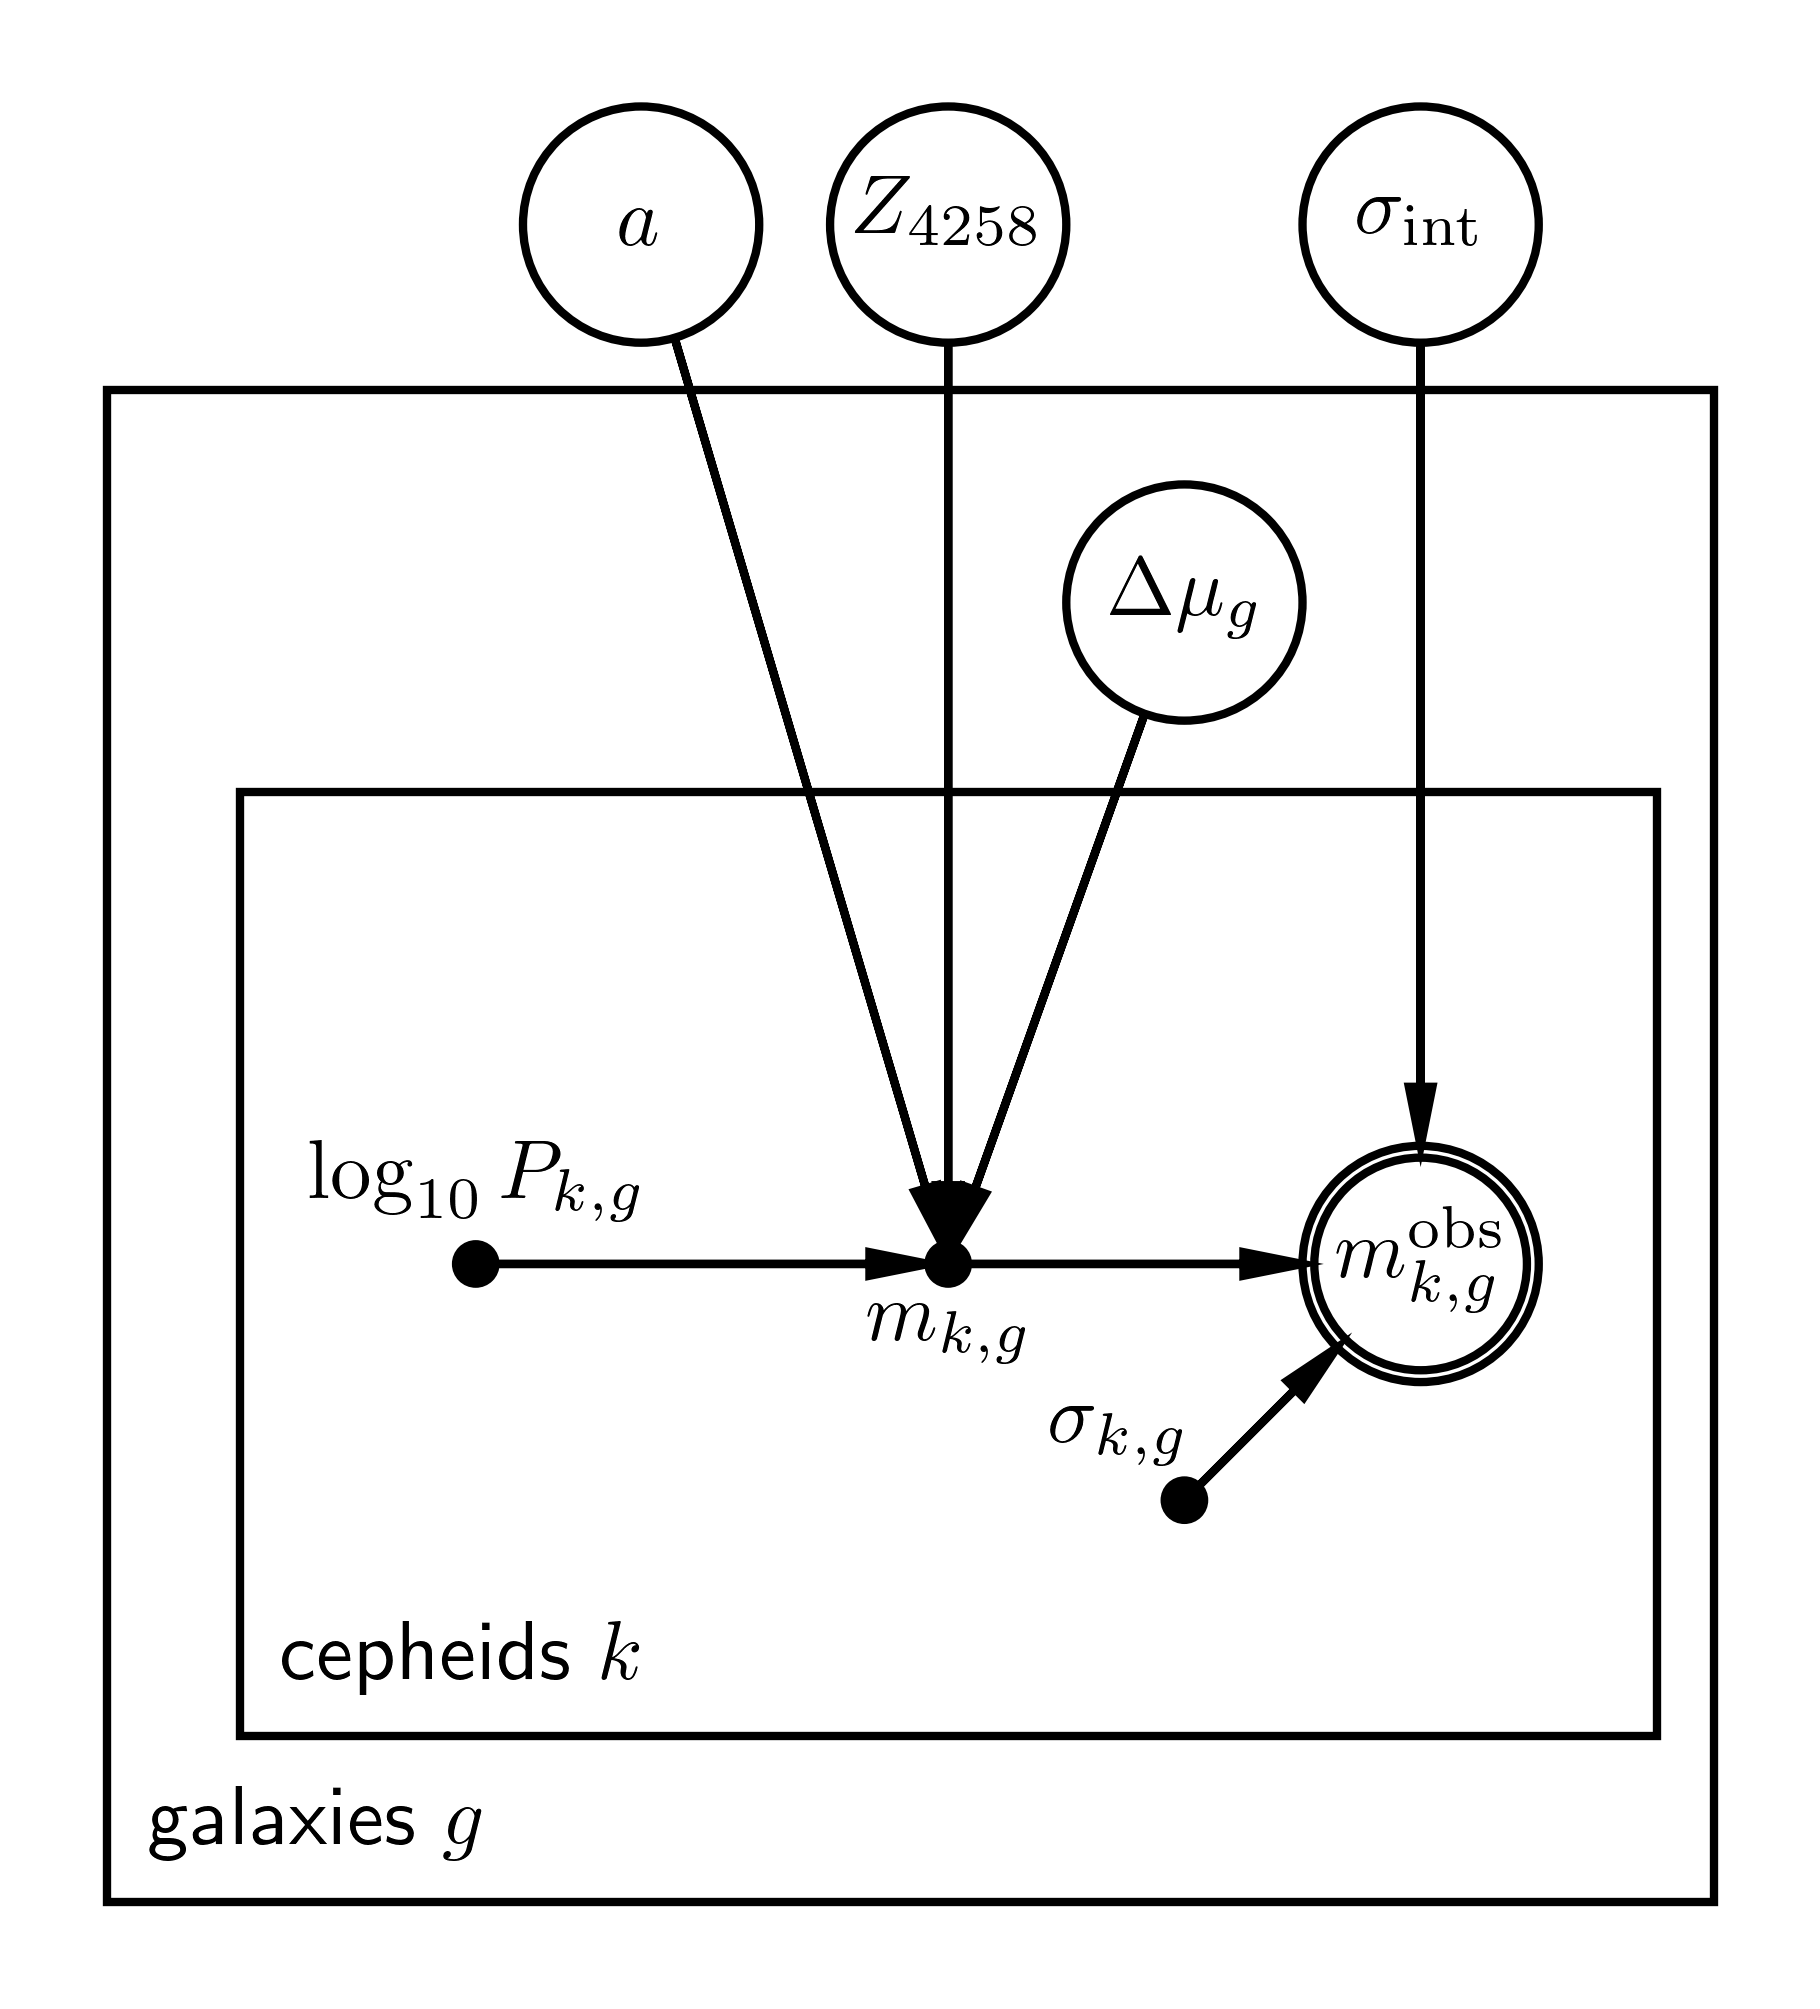

In [2]:
pgm = daft.PGM(observed_style="inner", dpi=300)
pgm.add_node("P", r'$\log_{10} P_{k,g}$', x=0, y=0, fixed=True)
pgm.add_node("m", r'$ m_{k,g}$', x=1, y=0, fixed=True, offset=(0, -16))
pgm.add_node("sig", r'$\sigma_{k,g}$', x=1.5, y=-0.5, fixed=True, offset=(-8,0))
pgm.add_node("dmu", r'$\Delta \mu_g$', x=1.5, y=1.4)
pgm.add_node('mobs', r'$m_{k,g}^{\mathrm{obs}}$', x=2, y=0, observed=True)
pgm.add_node("sigint", r'$\sigma_{\mathrm{int}}$', x=2, y=2.2)
pgm.add_node("Z", r'$Z_{4258}$', x=1, y=2.2)
pgm.add_node("a", r'$a$', x=0.35, y=2.2)

pgm.add_edge("P", "m")
pgm.add_edge("m", "mobs")
pgm.add_edge("sig", "mobs")
pgm.add_edge("dmu", "m")
pgm.add_edge('Z',"m")
pgm.add_edge("a", "m")
pgm.add_edge("sigint", "mobs" )

pgm.add_plate([-0.5, -1, 3, 2], "cepheids $k$", )
pgm.add_plate([-0.78, -1.35, 3.4, 3.2], "galaxies $g$", )
pgm.render()

## This model subtly had a population parameter and individual parameters $Z_{4258}$ and $\Delta\mu_g$

## This choice of parameterization was good 

## We only cared about the population parameter $Z_{4258}$ and could regard the $\Delta\mu$'s as nuisance parameters


# $$
\log H_{0}= \sum_{g} \frac{\left(m_{v, g}^{0}+5 a_{v}\right)-\left(\Delta \mu_{g}+Z_{4258}\right)+25}{5}
$$

(That's what the sum over $g$ is - marginalizing over all the galaxies)

## But we also forced all the cepheids in all the galaxies to obey the exact same P-L relation


## That's a modeling choice, but it may not be a very good one

<img src="all_gals.png">

## Yet, visibly, the cepehids do not all have vastly different slopes...


## So what we if we treated the P-L relation as a population parameter, but allowed each galaxy to vary a little?

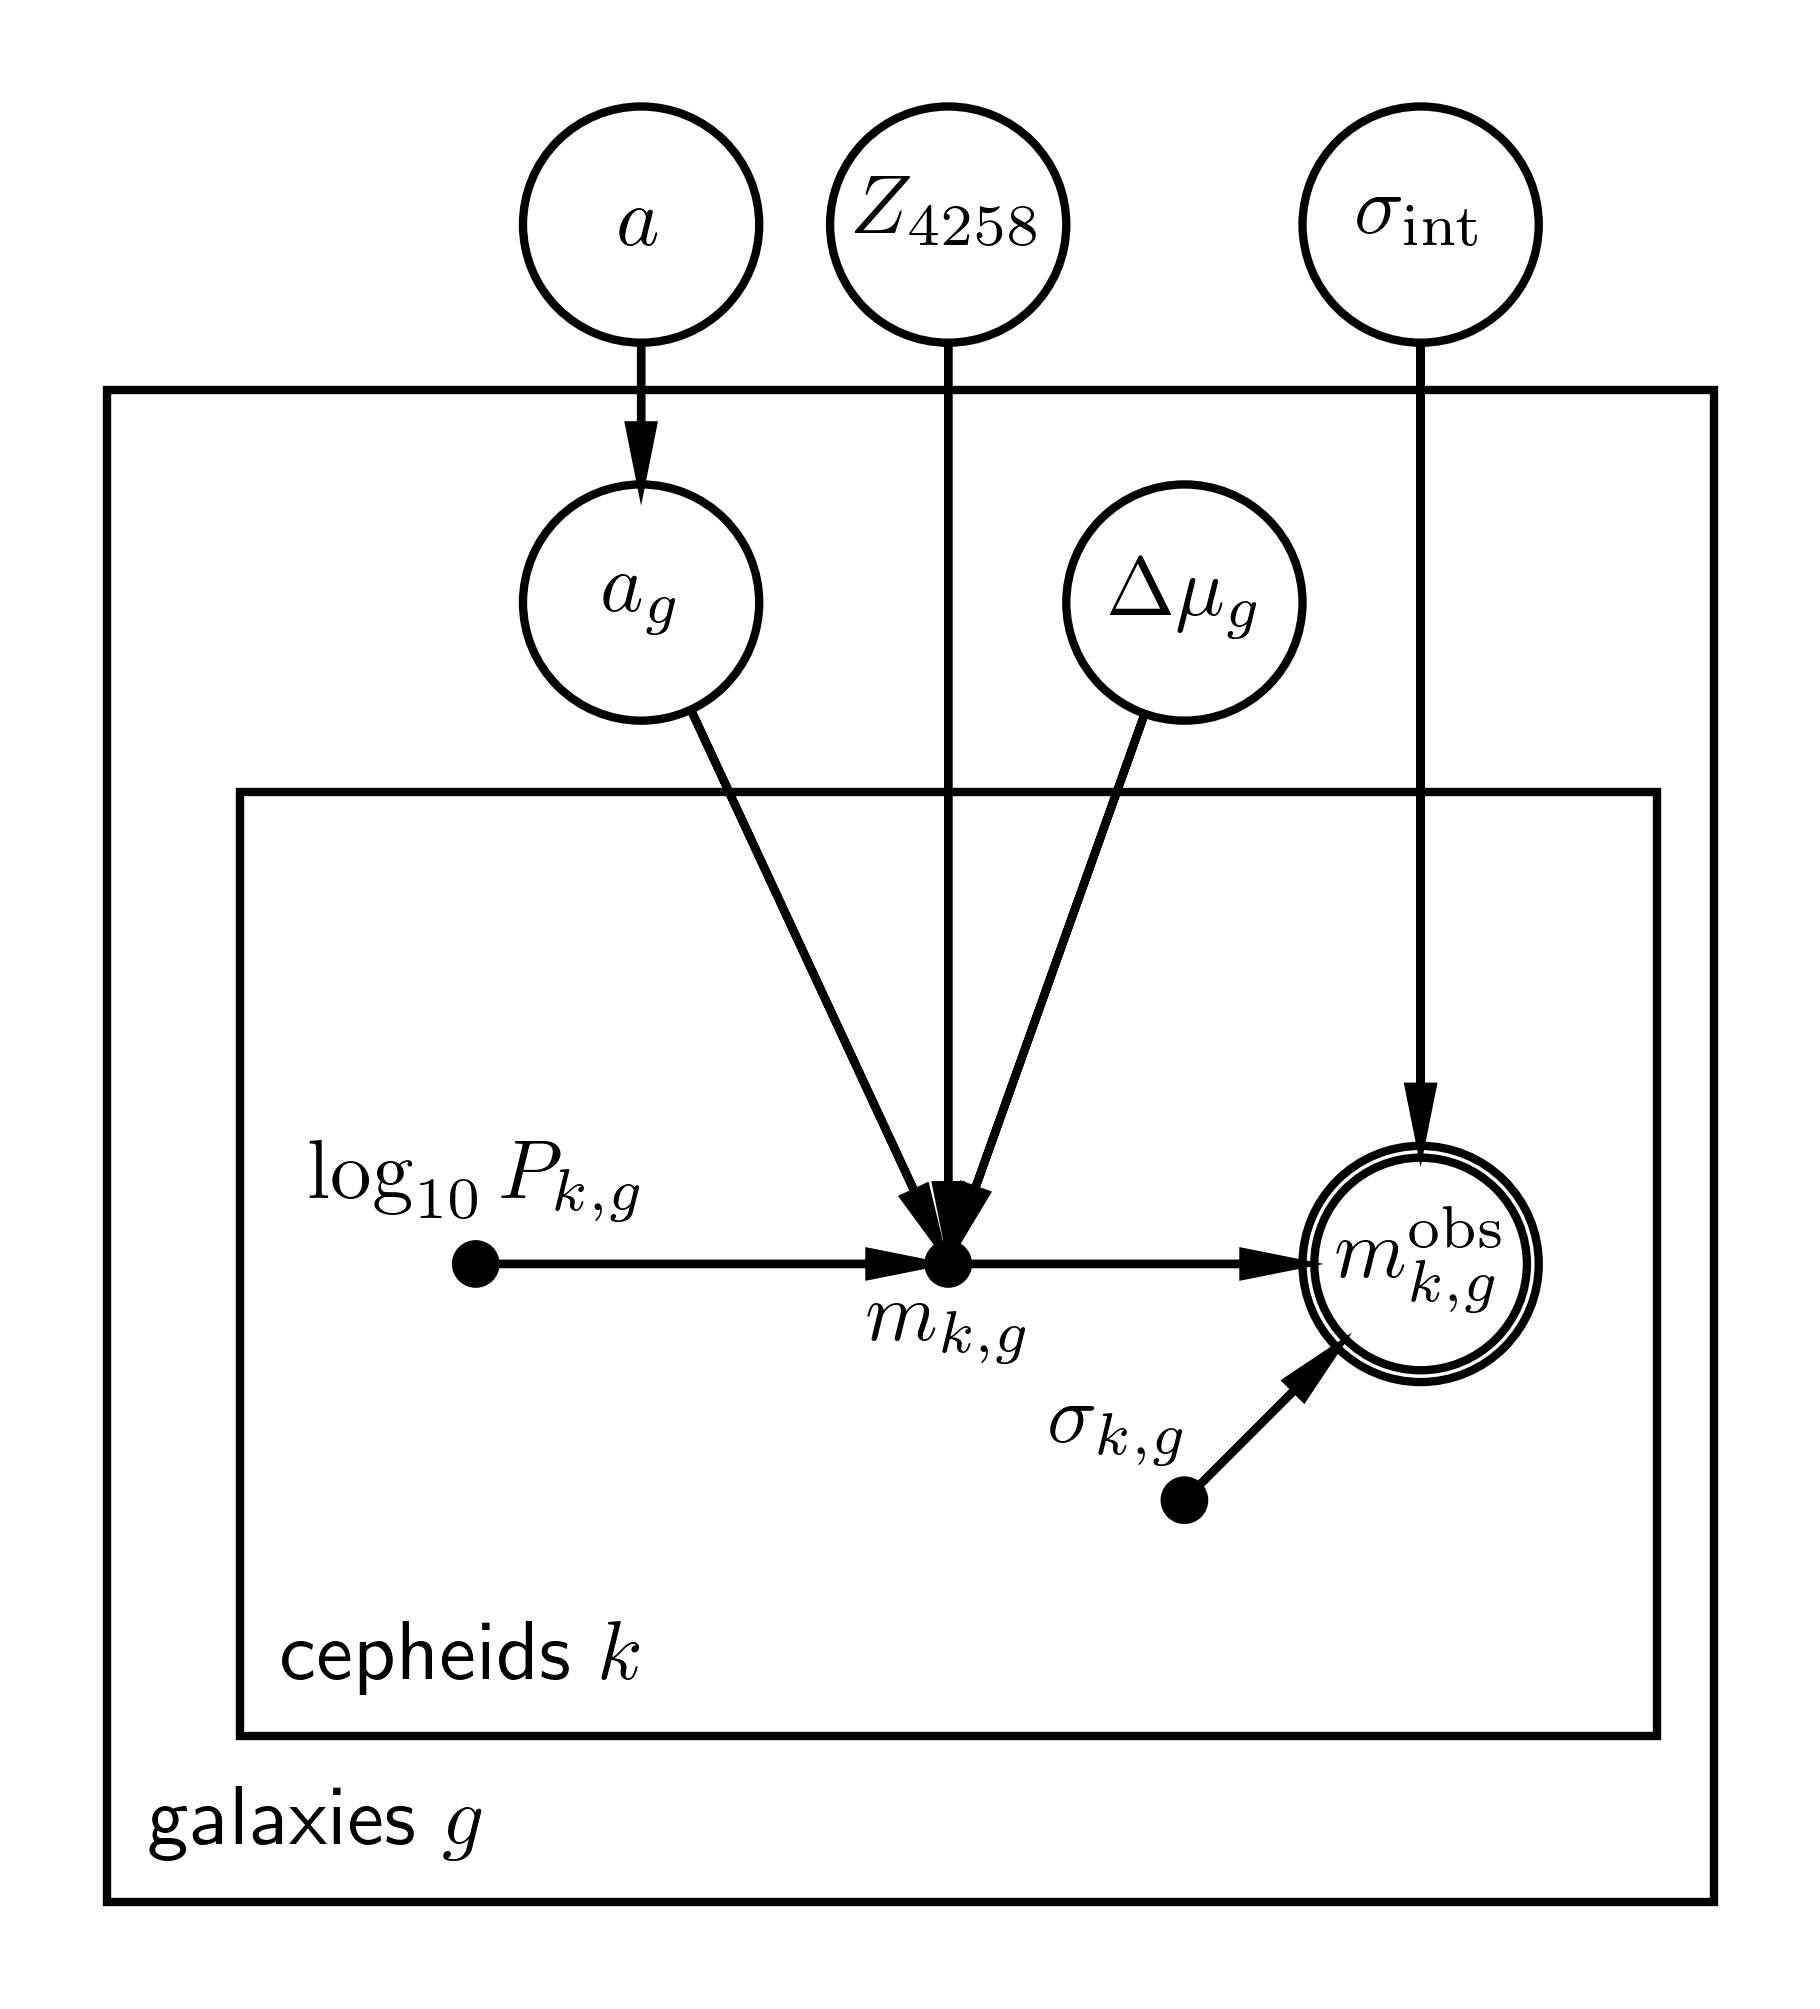

In [3]:
pgm = daft.PGM(observed_style="inner", dpi=300)
pgm.add_node("P", r'$\log_{10} P_{k,g}$', x=0, y=0, fixed=True)
pgm.add_node("m", r'$ m_{k,g}$', x=1, y=0, fixed=True, offset=(0, -16))
pgm.add_node("sig", r'$\sigma_{k,g}$', x=1.5, y=-0.5, fixed=True, offset=(-8,0))
pgm.add_node("dmu", r'$\Delta \mu_g$', x=1.5, y=1.4)
pgm.add_node('mobs', r'$m_{k,g}^{\mathrm{obs}}$', x=2, y=0, observed=True)
pgm.add_node("sigint", r'$\sigma_{\mathrm{int}}$', x=2, y=2.2)
pgm.add_node("Z", r'$Z_{4258}$', x=1, y=2.2)
pgm.add_node("a", r'$a$', x=0.35, y=2.2)
pgm.add_node("a_g", r'$a_g$', x=0.35, y=1.4)

pgm.add_edge("P", "m")
pgm.add_edge("m", "mobs")
pgm.add_edge("sig", "mobs")
pgm.add_edge("dmu", "m")
pgm.add_edge('Z',"m")
pgm.add_edge("a", "a_g")
pgm.add_edge("a_g", "m")
pgm.add_edge("sigint", "mobs" )

pgm.add_plate([-0.5, -1, 3, 2], "cepheids $k$", )
pgm.add_plate([-0.78, -1.35, 3.4, 3.2], "galaxies $g$", )
pgm.render()

# In-class Exercise/Experiment:

Implement this model in `pymc3`

In [4]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import pymc3 as pm

# same code as in midterm to load the data
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

# Lets implement the case of each galaxy treated independently of each other 

i.e. $2 N_{\text{host}}$ parameters - slope and intercept for each.

In [5]:
# define a likelihood for each Cepehid galaxy
def neg_log_like(theta, i):
    ceph.select(hosts[i])
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    b, mu = theta
    return np.sum((mobs - b*logP - mu)**2./(sigma_obs**2.))

results = {}


for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
  
    # fit each of the Cepehid galaxies
    res = minimize(neg_log_like, (-2., np.median(mobs)), args=(i,))
    print(res.x)
    results[ID] = res.x


[-1.90530766 27.62680334]
[-2.88122641 29.04952027]
[-3.02592305 29.07767626]
[-2.71848346 28.15185798]
[-2.48918861 27.52960865]
[-2.94832744 26.26490177]
[-2.83478737 27.57568316]
[-2.62746845 28.05924222]
[-2.78757566 28.2742838 ]


In [6]:
# just create an integer mapping for each host so we can use as an index
nhosts = len(hosts)
host_map = dict(zip(hosts, np.arange(len(hosts))))
host_idx = [host_map[str(int(x))] for x in ceph.data[:,1]]
host_idx = np.array(host_idx)
print(host_map)

mobs = ceph.data[:,2]
err  = ceph.data[:,3]
logP = np.log10(ceph.data[:,4])

{'1309': 0, '3021': 1, '3370': 2, '3982': 3, '4038': 4, '4258': 5, '4536': 6, '4639': 7, '5584': 8}


In [7]:
with pm.Model() as hierarchical_model: 

    # Hyperpriors for group nodes
    mu_a = pm.Normal('slope', mu=-3, sigma=0.5)
    sigma_a = pm.HalfNormal('slopescatter', 0.5)
    sigma_b = pm.HalfNormal('dmuscatter         ', 5.)
    Z = pm.Normal('Z', mu=25, sigma=5.)
    
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=nhosts)
    dmu = pm.Normal('dmu', mu=0, sigma=sigma_b, shape=nhosts)
    
    sig_int = 0.1
    
    mpred = a[host_idx]*logP + Z + dmu[host_idx]
    like = pm.Normal('likelihood', mu=mpred, sigma =np.sqrt(sig_int**2. + err**2), observed=mobs)
    
    hm = pm.sample(2000, tune=500, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dmu, a, Z, dmuscatter         , slopescatter, slope]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [01:07<00:00, 73.89draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
res_hm = pm.summary(hm)
res_hm

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
slope,-2.753,0.106,-2.943,-2.551,0.002,0.002,2030.0,2030.0,2057.0,2834.0,1.0
Z,28.021,0.356,27.331,28.668,0.012,0.008,927.0,927.0,950.0,1054.0,1.0
a[0],-2.418,0.253,-2.883,-1.968,0.008,0.006,997.0,947.0,947.0,1203.0,1.0
a[1],-2.745,0.200,-3.116,-2.342,0.003,0.002,3700.0,3700.0,3705.0,2860.0,1.0
a[2],-2.912,0.122,-3.134,-2.672,0.002,0.002,3193.0,3120.0,3277.0,2747.0,1.0
a[3],-2.790,0.185,-3.147,-2.439,0.003,0.002,3462.0,3398.0,3488.0,2504.0,1.0
a[4],-2.614,0.162,-2.932,-2.336,0.004,0.003,1663.0,1641.0,1653.0,1819.0,1.0
a[5],-2.945,0.071,-3.079,-2.814,0.001,0.001,2957.0,2957.0,2957.0,2410.0,1.0
a[6],-2.836,0.093,-3.011,-2.665,0.001,0.001,5050.0,5033.0,5029.0,2833.0,1.0
a[7],-2.673,0.192,-3.040,-2.327,0.004,0.003,2238.0,2238.0,2338.0,2822.0,1.0


/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs ha

/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs ha

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2d9f2710>,
      dtype=object)

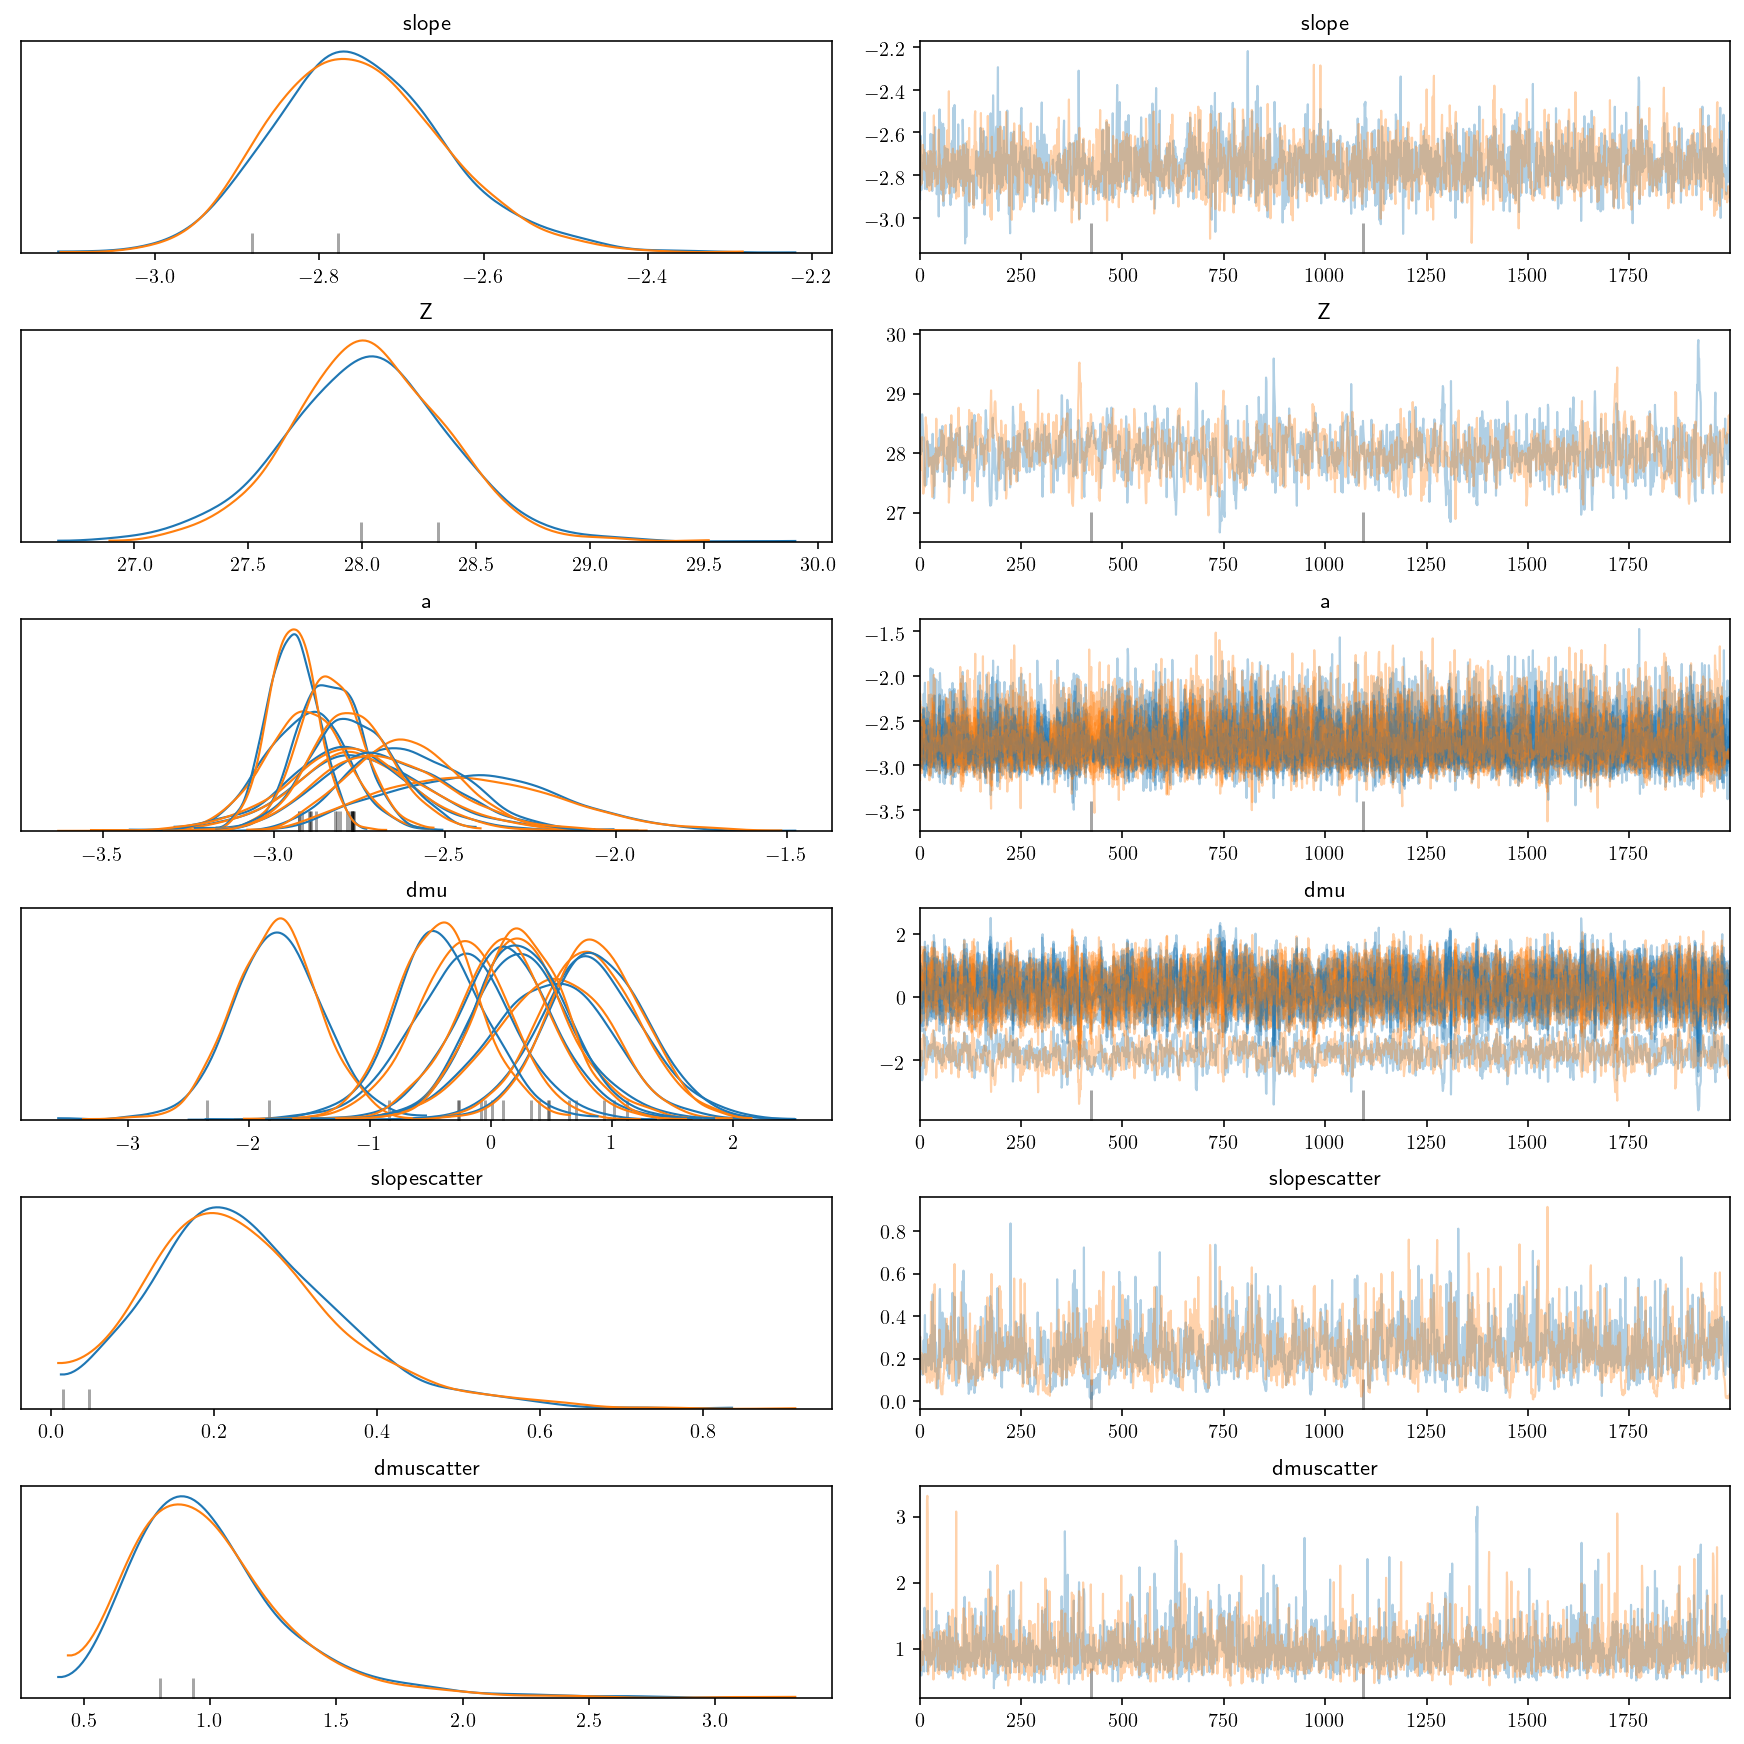

In [9]:
pm.traceplot(hm)

Text(0, 0.5, 'Slope')

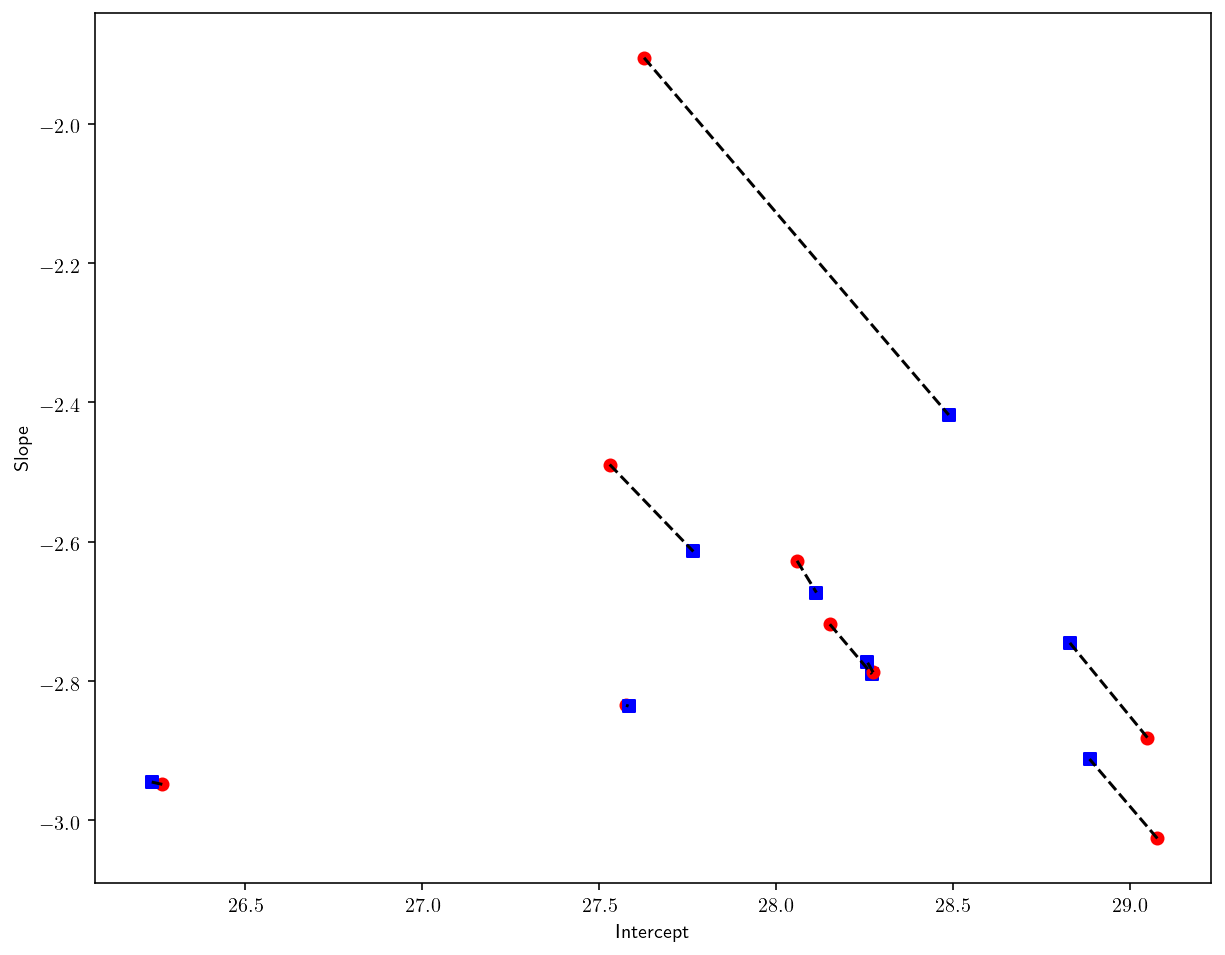

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i, host in enumerate(hosts):
    old_slope, old_intercept = results[host]
    new_slope = res_hm.loc[f'a[{i}]']['mean']
    new_intercept = res_hm.loc[f'dmu[{i}]']['mean'] + res_hm.loc['Z']['mean']
    ax.scatter(old_intercept, old_slope, color='r', marker='o')
    ax.scatter(new_intercept, new_slope, color='b', marker='s')
    ax.plot([old_intercept, new_intercept], [old_slope, new_slope], 'k--')
    
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')

# Missing Information and Selection Effects

**What does "missing information" mean?**

In physics, we're used to the idea that we never have complete information about a system.

Trivial example: non-zero measurement errors mean that we're missing some information, namely the true value of whatever we've measured. We deal with this by incorporating that fact into our model, via the sampling distribution.

Hierachical models tend to be full of such unobservable parameters, including things like group membership.

**Key messages**

1. No data set is perfectly complete (especially in astronomy!)
2. It's our job to know whether that incompleteness can be ignored for the purpose of our inference
3. If not, we need to model it appropriately and marginalize over our ignorance

**More missingness mechanisms**

Two more ways that data can be missing are extremely common in astrophysics, and especially in surveys. In statistics, these are called **censoring** and **truncation**.

These are related (though not one-to-one) with the astronomical terms **Malmquist bias** and **Eddington bias**.

**Censoring**: a given data point (astronomical source) is known to exist, but a relevant measurement for it is not available.

This refers both to completely absent measurements and upper limits/non-detections, although the latter case is more common and more useful because the detection limit still has information.

**Truncation**: not only are measurements missing, but the total number of sources that *should* be in the data set is unknown.

In other words, the lack of a measurement means that we don't even know about a particular source's existence.

**Malmquist bias** refers to the fact that flux-limited surveys have an effective *luminosity* limit for detection that rises with distance (redshift). Thus, the sample of measured luminosities is not representative of the whole population.

<img src="missing_malquist.png">

**Eddington bias** refers to the effect of noise or scatter on a luminosity function, $N(>L)$, the number of sources in some population more luminous than $L$.

Because the true $N(>L)$ is usually steeply decreasing in practice, and extends below the survey flux limit, scatter in measurements of $L$ can have a big impact on the measured luminosity function.

This is a histogram rather than $N(>L)$, but you get the idea.

<img src="missing_eddington.png">

The terms Malmquist and Eddington bias were coined in relatively specific contexts. 

Usually, it's more accurate to say that a given data set is impacted by selection effects.

## Example

Consider the (real) case of a flux-limited galaxy cluster survey. 

Cluster luminosities scale with mass, and the mass function (hence also the luminosity function) is steeply decreasing. 

The number of clusters as a function of mass and redshift, and the luminosity-mass relation, are both of interest.

<img src="missing_RASS_zL.png" >

**Complilation of ROSAT All-Sky Survey cluster detections**

<table>
    <tr>
        <th><img src="missing_expn_full.png"></th>
        <th><img src="missing_expn_trun.png"></th>
    </tr>
</table>

**Fictional luminosity-mass data, applying a threshold for detection**

**Coping with missing information**

Ideally, we should include the "selection" process that determines which data are observed and which are not in our model. 

i.e. we need to expand the model to include things like undetected sources.


* Priors (models for things that aren't observed) are going to matter!

## Formally Modelling Missing Information

Adopting notation from *Bayesian Data Analysis* (Gelman et al. 2004)
* $y_\mathrm{obs}$ and $y_\mathrm{mis}$ are the observed and unobserved data, and $y=y_\mathrm{obs}\cup y_\mathrm{mis}$
* $I$ is a vector of indicator variables (0 or 1) telling us whether a given y is observed or not
* $\theta$ is the set of parameters needed to model a completely observed data set
* $\phi$ are any additional parameters needed to model the selection process


(if this is starting to sound like the Gaussian mixture model where we had inliers and outliers, that's because it is)

The likelihood associated with a complete data set would be just

# $$p(y|\theta)$$


For our partially missing data set, this needs to also account for the inclusion parameters, $I$

# $$p(y,I|\theta,\phi) = p(y|\theta)\,P(I|\phi,y)$$

In other words, inclusion is part of the observed data vector

Expanding out the $y$s,

## $$p(y_\mathrm{obs},y_\mathrm{mis},I|\theta,\phi) = p(y_\mathrm{obs},y_\mathrm{mis}|\theta)\,P(I|\phi,y_\mathrm{obs},y_\mathrm{mis})$$


This isn't yet a likelihood for the *observed* data, however. For that we need to marginalize over the  $y_\mathrm{mis}$.

## $$p(y_\mathrm{obs},I|\theta,\phi) = \int dy_\mathrm{mis} \, p(y_\mathrm{obs},y_\mathrm{mis}|\theta)\,P(I|\phi,y_\mathrm{obs},y_\mathrm{mis})$$

Note that we no longer have a clean separation between data and parameters in the PGM sense.

This is the usual duality that we get with Bayes' theorem - **data are just parameters that we happen to observe**

Thinking of drawing a PGM, the $y$ nodes can be fixed by observation *or* be nuisance parameters, depending on the corresponding element of $I$.

Either way they go in a double circle because they come from a sampling distribution. 

**Our model must include a sampling distribution even for putative sources that aren't in our data set!**

## When can we ignore selection?

Consider the likelihood in this form

## $$p(y_\mathrm{obs},I|\theta,\phi) = \int dy_\mathrm{mis} \, p(y_\mathrm{obs},y_\mathrm{mis}|\theta)\,P(I|\phi,y_\mathrm{obs},y_\mathrm{mis})$$

We can get away with ignoring the selection process if the posterior for the parameters of interest $p(\theta|y_\mathrm{obs},I)$ is equivalent to simply $p(\theta|y_\mathrm{obs})$.

## $$p(\theta|y_\mathrm{obs},I)$$

## $$= \int d\phi\int dy_\mathrm{mis} \, p(y_\mathrm{obs},y_\mathrm{mis}|\theta) \, P(I|\phi,y_\mathrm{obs},y_\mathrm{mis}) \, p(\theta,\phi)$$

## $$= p(\theta|y_\mathrm{obs})$$ 

## OK so when does that work?

This requires two things to be true:

1. Selection doesn't depend on (potentially) unobserved data: $P(I|\phi,y_\mathrm{obs},y_\mathrm{mis}) = P(I|\phi,y_\mathrm{obs})$

2. Priors for the interesting ($\theta$) and selection-related ($\phi$) parameters are independent: $p(\theta,\phi)=p(\theta)p(\phi)$

# Example: galaxy cluster scaling relations

Imagine we're fitting the relation between mass ($x$) and luminosity ($y$) for clusters. 

(Fictional, error-free data for illustration.)

<img src="missing_complete_xy.png" width=50%>

To start with, we'll assume a complete data set like we've done thus far. 

Then the forward model needs
* true values of mass ($x$) for the $N$ clusters
* true values of luminosity $y$ for each cluster, determined by a mean relation and scatter, parametrized by $\theta$
* sampling distributions for $x$ and $y$, which we'll assume are independent
* prior distributions for $x$ (with some parameters $\Omega$) and $\theta$

## $$p(\hat{x},\hat{y},x,y,\theta,\Omega)= p(\theta,\Omega)\prod_{k=1}^N p(x_k|\Omega)\,p(y_k|x_k,\theta)\,p(\hat{y}_k|y_k)\,p(\hat{x}_k|x_k)$$

<img src="missing_complete_pgm.png">

Now let's imagine we have data only for clusters that exceed some threshold luminosity for detection (blue points).

<img src="missing_truncy_xy.png">

The data need to be augmented by the inclusion vector, $I$, which implicitly encodes the number of detected clusters, $N_\mathrm{det}$.

The model must expand to contain $\phi$ and the total number of clusters, $N$ (since this is a truncation problem).

Before drawing the PGM, let's have a look at the new likelihood:

### $$P(\hat{x},\hat{y},I,N_\mathrm{det}|x,y,\theta,\Omega,\phi,N)= {N \choose N_\mathrm{det}} \,P(\mathrm{detected}~\mathrm{clusters}) \,P(\mathrm{missing}~\mathrm{clusters})$$

Note that a binomial term, ${N \choose N_\mathrm{det}}$ has sneakily appeared.

The reason for this is subtle, and has to do with the statistical concept of *exchangeability* 

Here the fully observed data are a priori exchangeable with one another, as are the partially observed data, but the the full data set contains these two non-exchangeable classes.

It helps to think in terms of the generative model here. Because the order of data points holds no meaning for us, the binomial term is there to reflect the number of ways we might generate completely equivalent (except for the ordering) data sets.

The term for detected clusters is what we had before, with the addition of the detection probability:

## $$P(\mathrm{detected}~\mathrm{clusters}) =$$

## $$\prod_{k=1}^{N_{det}} p(x_k|\Omega)\,p(y_k|x_k,\theta)\,p(\hat{y}_k|y_k)\,p(\hat{x}_k|x_k)\,P(I_k=1|\hat{y}_k,\phi)$$

The term for missing clusters is similar, but must be marginalized over the unobserved $\hat{x}$ and $\hat{y}$ subject to the constraint that these clusters not be detectable:

## $$P(\mathrm{missing}~\mathrm{clusters}) =$$

## $$\prod_{k=1}^{N-N_{det}} \int d\hat{x}\,d\hat{y}\, p(x_k|\Omega)\,p(y_k|x_k,\theta)\,p(\hat{y}_k|y_k)\,p(\hat{x}_k|x_k)\,P(I_k=0|\hat{y}_k,\phi)$$.

All terms in the product are equal once we marginalize over $x_k$ and $y_k$, so this is will simplify to

# $$P_{mis}^{N_{mis}}$$

with $N_{mis}=N-N_{det}$ and $P_{mis}$ the a priori probability of a cluster going undetected.

Rather than going on to manipulate this further, just note that the additions to the data/model boil down to
1. A $P(I_k|\ldots)$ term within the product over clusters
1. Additional terms depending on $N$, $N_{det}$, $\phi$ and other **global/population parameters.**

## Hence the PGM:
<img src="missing_truncy_pgm.png">

## For comparison

<table>
<tr>
<td><img src="missing_complete_pgm.png"></td>
<td><img src="missing_truncy_pgm.png"></td>
</tr>
</table>

## Now the big question: is selection ignorable? 

* Do we need all this formalism to do inference on $\Omega$ and/or $\theta$?

<img src="missing_truncy_xy.png">

**Are the priors for $\theta$ and $\phi$ independent?**

Yes, at least as drawn in the PGM. And usually this is the assumption.

**Is selection independent of (potentially) unobserved data ($\hat{x}_k$ and $\hat{y}_k$)?**

Heck no. 

The detection probability explicitly depends on $\hat{y}_k$.

The brighter the cluster, the more likely you are to detect the thing...